In [41]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.providers.aer import Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram

## The $|+\rangle$ state

$$
\begin{equation}\nonumber
        \begin{gathered}
          |\psi\rangle = \cos\left(\frac{\pi}{4}\right)|0\rangle+e^{i0}\sin\left(\frac{\pi}{4}\right)|1\rangle \\[0.5em]
          \Rightarrow |\psi\rangle = |+\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)
          = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ 1\end{bmatrix}
         \end{gathered} 
      \end{equation}
$$

In [42]:
qc = QuantumCircuit(1,1)

# Initialization of the state
init_state = [1/np.sqrt(2), 1/np.sqrt(2)]
qc.initialize(init_state, 0)

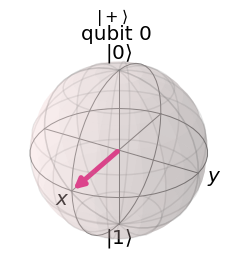

In [43]:
# Show the init state on the blochsphere
sim = Aer.get_backend("aer_simulator")

qc.save_statevector()
statevector_init = sim.run(qc).result().get_statevector()

plot_bloch_multivector(statevector_init, "$|+\\rangle$")

In [44]:
qc.measure(0, 0)

# Run the circuit
t_circuit = transpile(qc, sim)
qobj = assemble(t_circuit, shots=1024)
results = sim.run(qobj).result()
answer = results.get_counts()

answer

{'1': 501, '0': 523}

---

## The $|+\rangle$ state can also be created with a hadamard-gate
$$
H|0\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} =
\frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix}
$$

In [45]:
init_state = [1, 0]   # |0>

qc = QuantumCircuit(1)
qc.initialize(init_state, 0)
qc.h(0)

qc.draw()

┌─────────────────┐┌───┐
q: ┤ Initialize(1,0) ├┤ H ├
   └─────────────────┘└───┘

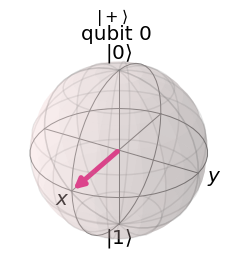

In [46]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector, "$|+\\rangle$")

---

## Quantum Fourier Transformation
+ For 3-Qubits 
$$|101\rangle \xrightarrow{QFT} |\tilde{101}\rangle$$

In [47]:
qc_qft = QuantumCircuit(3)
qc_qft.x(0)
qc_qft.x(2)

qc_qft.h(0)
qc_qft.cp(np.pi/2, 0, 1)
qc_qft.cp(np.pi/4, 0, 2)

qc_qft.h(1)
qc_qft.cp(np.pi/2, 1, 2)

qc_qft.h(2)
qc_qft.draw()

┌───┐┌───┐                                     
q_0: ┤ X ├┤ H ├─■────────■──────────────────────────
     └───┘└───┘ │P(π/2)  │       ┌───┐              
q_1: ───────────■────────┼───────┤ H ├─■────────────
     ┌───┐               │P(π/4) └───┘ │P(π/2) ┌───┐
q_2: ┤ X ├───────────────■─────────────■───────┤ H ├
     └───┘                                     └───┘

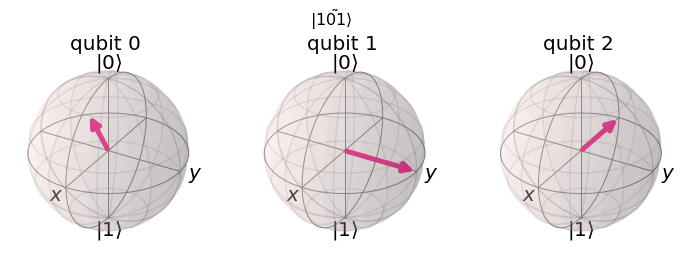

In [48]:
qc_qft.save_statevector()
statevector_qft = sim.run(qc_qft).result().get_statevector()
plot_bloch_multivector(statevector_qft, "$|\\tilde{101}\\rangle$")

In [49]:
#transpiled_qc = transpile(qc_qft, sim)
#job = sim.run(transpiled_qc, shots=1024)
#counts = job.result().get_counts()
#plot_histogram(counts)

---

## Quantum Phase Estimation 
+ For $U = P\left(\phi = \frac{\pi}{2}\right)$
+ With $n=3$ Qubits

In [50]:
n_qubits = 3
qpe = QuantumCircuit(4, n_qubits)
qpe.x(n_qubits)   # |1> as Eigenvektor

for qubit in range(n_qubits):
    qpe.h(qubit)

In [51]:
# controlled unitary P(pi/2)  
qpe.cp(np.pi/2, 2, 3)

qpe.cp(np.pi/2, 1, 3)
qpe.cp(np.pi/2, 1, 3)

for i in range(4):
    qpe.cp(np.pi/2, 0, 3)

In [52]:
# inverse QFT
qpe.h(0)
qpe.cp(-np.pi/2, 0, 1)
qpe.cp(-np.pi/4, 0, 2)

qpe.h(1)
qpe.cp(-np.pi/2, 1, 2)

qpe.h(2)
qpe.draw()

┌───┐                                                               ┌───┐»
q_0: ┤ H ├────────────────────────────■────────■────────■────────■───────┤ H ├»
     ├───┤                            │        │        │        │       └───┘»
q_1: ┤ H ├──────────■────────■────────┼────────┼────────┼────────┼────────────»
     ├───┤          │        │        │        │        │        │            »
q_2: ┤ H ├─■────────┼────────┼────────┼────────┼────────┼────────┼────────────»
     ├───┤ │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)      »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                             
«q_0: ─■─────────■────────────────────────────
«      │P(-π/2)  │        ┌───┐               
«q_1: ─■─────────┼────────┤ H ├─■─────────────
«                │P(-π/4) └───┘ │P(-π/2) ┌───┐
«q_2: ───────────■──────────────■────────┤ H ├
«                                        └───┘
«q_3: ────────────────────────────────────────
«                                             
«c: 3/════════════════════════════════════════
«

In [53]:
# measure
qpe.measure(0, 0)
qpe.measure(1, 1)
qpe.measure(2, 2)

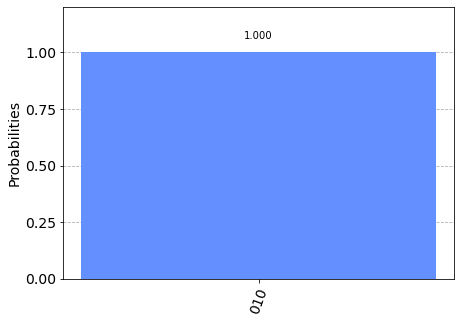

In [54]:
t_qpe = transpile(qpe, sim)
qobj = assemble(t_qpe, shots=1024)
results = sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Divide the result by $2^n \Rightarrow \frac{2}{2^3}$   